In [1]:
from pathlib import Path
import sys
import yaml
import time
import os
import copy

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import lines

DIR = Path('..')
sys.path.insert(0, str(DIR))
from SCanalyzer import SCanalyzer
from SCanalyzer.busSim import BusSim, Config
from SCanalyzer.busSim.manager import managerFactory
from SCanalyzer.gtfs_edit import edit_double
from SCanalyzer.util import findEPSG
from pyproj import Transformer

import matplotlib.pyplot as plt
from matplotlib import lines

import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

from shapely import geometry

%matplotlib inline

manger init
mangager register
mangager register


In [2]:
def get_yelp_api_key():
    with open("../config.yml", 'r') as yml:
        cfg = yaml.safe_load(yml)
        return cfg["yelp"]["api_key"]

def plot_background(crs):
    background_path = os.path.join('..', 'data', 'plot', 'background_stlouis')
    city = gpd.read_file(os.path.join(background_path, "stl_boundary")).to_crs(crs)
    #lakes = gpd.read_file(os.path.join(background_path, "water-meter-shp")).to_crs(crs)
    street = gpd.read_file(os.path.join(background_path, "streets")).to_crs(crs)
    # city = gpd.read_file(background_path + "madison-shp")
    # lakes = gpd.read_file(background_path + "water-shp")
    # street = gpd.read_file(background_path + "street-shp")

    ax = city.plot(color="lightgray", alpha=.2, figsize=(12, 12), zorder=2)
    #lakes.plot(color="lightblue", ax=ax, zorder=1, alpha=0.8)
    street.plot(color="darkgray", alpha = .5, ax=ax, zorder=3)
    return ax

# route remove study

In [3]:
api_key = 'ZsHZFGtKEZeOOXhTne98eErmfd6BfNTm9GqO2S6inSnWzDwtgC2sEauXcB-8zUna_lXZEal4jsW_St6O0OQOcuNvifrr6uqNYmjFXW-FyVKvaMyczbihWELI80tjYHYx'
gtfo = SCanalyzer(os.path.join('..', 'data', 'lansing_gtfs.zip'))
census_gdf = gtfo.load_census()
services_gdf = gtfo.load_yelp(api_key=api_key)

stops_meter exists


In [4]:
services_gdf

,id,service,name,latitude,longitude
0,32dPMAa3vC1eeih8ZfGCIw,banks,Bank of America Financial Center,38.643353,-90.260601
1,eD1Yct398nNK4PHf4X3vMQ,banks,Bank of America Financial Center,38.647589,-90.309282
2,0U7SVrpHBkXg1Ka5TEXKbA,banks,Pulaski Bank,38.644540,-90.261810
3,Ns1mgVrGKCxTv_ZGM9K7Vg,banks,Chase Bank,38.628834,-90.341978
4,beKlLgyJBBVtqENIUQ-NtA,banks,First Community Credit Union,38.672690,-90.421200
...,...,...,...,...,...
2142,wjDtIbM5VOY9G9AOQvKKAA,supermarket,Schnucks - Cottleville,38.745250,-90.636860
2143,IVN1857u-6C4jCWbQfkOVw,supermarket,Hanlen's Meat Shoppe & Catering,38.599400,-90.413090
2144,qQSscPMhk3frtSNilF1cGA,supermarket,VOM FASS,38.612877,-90.317635
2145,YNFkP6HqZxwbv-2YMPyZtQ,supermarket,Crystal & Spice Shoppe,38.513344,-89.979347


In [5]:
# routes = [ 2,  4,  5,  6,  7,  8, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21, 22,
#        23, 26, 27, 30, 31, 32, 33, 36, 39, 40, 44, 48, 49, 50, 51, 52, 55,
#        67, 70, 72, 73, 75, 59, 63, 68, 78, 80, 84, 81, 82]

routes = [80]
for route in routes:
    print(route)
    gtfo.set_batch_label(f"{route}-rm")
    config = Config(day="monday", elapse_time="00:20:00", interval="08:00:00", max_walking_min=10, route_remove=[])
    config.set_starts(centroids=census_gdf)

    perf_df = pd.DataFrame(
            columns=["geometry", "start_time", "search_time", "add_service_time", "add_census_time"])
    result_gdf = gtfo.search(config, perf_df)
    gtfo.add_service_metrics(result_gdf, services_gdf, perf_df)
#     gtfo.add_demographic_metrics(result_gdf, census_gdf, perf_df)
    result_gdf.to_csv(os.path.join('.', 'out', f'result{route}.csv'), index=False)
    perf_df.to_csv(os.path.join('.', 'out', f'perf{route}.csv'), index=False)

80
get available manager
manager create
self=<SCanalyzer.busSim.manager.managerFactory.ManagerFactory object at 0x7f943ad38a30>
key='local'
manager=<class 'SCanalyzer.busSim.manager.localManager.LocalManager'>
Empty DataFrame
Columns: [geometry, start_time, search_time, add_service_time, add_census_time]
Index: []


100%|██████████| 5082/5082 [01:15<00:00, 67.57it/s]


In [6]:
def get_score(area, banks=0, clinics=0, dentists=0, hospitals=0, supermarkets=0):
    x6 = 1
    if banks == 0:
        x6 = x6/2
    if supermarkets == 0:
        x6 = x6/2
    if hospitals == 0:
        x6 = x6/2
    if clinics == 0:
        x6 = x6/2
    if dentists == 0:
        x6 = x6/2
    score = (area + banks + clinics + hospitals + dentists + supermarkets) * x6
    return score

In [7]:
result_gdf[result_gdf['banks'] != 0]

,geometry,start_time,map_identifier,banks,clinics,dentists,hospitals,supermarket


In [8]:
#result_gdf[result_gdf['score'] != 0]

<AxesSubplot:>

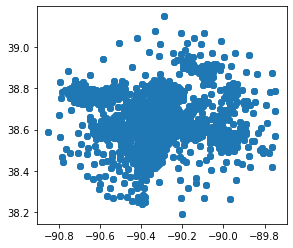

In [9]:
gpd.GeoSeries(result_gdf['geometry']).plot()

In [10]:
def plot_preferred_points(result_gdf, city_gpd=None):
    if city_gpd is None:
        polys = [[p.x, p.y] for p in result_gdf['geometry']]
        ax = gpd.GeoSeries(geometry.Polygon(polys).convex_hull).plot(color="lightgrey", alpha=0.5)
    else:
        ax = city_gpd.plot(color="grey", alpha=0.5)
    result_gdf['score'] = result_gdf.apply(axis=1, func=lambda row: get_score(0, row['banks'], row['clinics'], row['dentists'], row['hospitals'], row['supermarket']))
    results = result_gdf[result_gdf['score'] != 0].sort_values('score')
    points_low = results.head(10)
    points_high = results.tail(10)
    gpd.GeoSeries(points_low['geometry']).plot(ax=ax, color="red")
    gpd.GeoSeries(points_high['geometry']).plot(ax=ax, color="green")
    points = {"low": [(p.y, p.x) for p in points_low['geometry']],
    "high": [(p.y, p.x) for p in points_high['geometry']]}

    lineslist = []
    lineslist.append(lines.Line2D([],[],color="white", markerfacecolor = "red", marker = "o", markersize=10, label = "low score"))
    lineslist.append(lines.Line2D([],[],color="white", markerfacecolor = "green", marker = "o", markersize=10, label = "high score"))
    ax.legend(handles = lineslist, loc="upper left",prop={"size": 10})
    plt.axis("off")
    plt.savefig("Madison_startpoints.png", dpi=300, bbox_inches="tight")
    print(points)


In [12]:
#city = gpd.read_file("../data/plot/background/madison-shp")
#minneapolis = gpd.read_file("../data/minneapolis/minneapolis.shp")
stlouis = gpd.read_file("../data/plot/background/stlouis")

DriverError: '../data/plot/background/stlouis' not recognized as a supported file format.

In [ ]:
plot_preferred_points(result_gdf=result_gdf, city_gpd=stlouis)

# route doubling study

In [ ]:
print(perf_df)

In [ ]:
sc = SCanalyzer(os.path.join('..', 'data', 'stlouis_gtfs.zip'))
census_gdf = sc.load_census()
services_gdf = sc.load_yelp(api_key=api_key)
config = Config(day="monday", elapse_time="00:30:00", interval="2:10:00", max_walking_min=10)
config.set_starts(centroids=census_gdf)

routes = [ 2,  4,  5,  6,  7,  8, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21, 22,
       23, 26, 27, 30, 31, 32, 33, 36, 39, 40, 44, 48, 49, 50, 51, 52, 55,
       67, 70, 72, 73, 75, 59, 63, 68, 78, 80, 84, 81, 82]
routes = [80]

result_folder = os.path.join('.', 'out', 'result')
perf_folder = os.path.join('.', 'out', 'perf')
if not os.path.exists(result_folder): os.makedirs(result_folder)
if not os.path.exists(perf_folder): os.makedirs(perf_folder)

for route in routes:
    print(route)
    sc.gtfs_edit(edit_double, route)
    sc.set_batch_label(f"{route}-double")
    perf_df = pd.DataFrame(
            columns=["geometry", "start_time", "search_time", "add_service_time", "add_census_time"])
    result_gdf = sc.search(config, perf_df)
    sc.add_service_metrics(result_gdf, services_gdf, perf_df)
    sc.add_demographic_metrics(result_gdf, census_gdf, perf_df)
    result_gdf.to_csv(os.path.join('.', 'out', 'result', f'result{route}-double.csv'), index=False)
    perf_df.to_csv(os.path.join('.', 'out', 'perf', f'perf{route}-double.csv'), index=False)
    break

In [ ]:
sc = SCanalyzer(os.path.join('..', 'data', 'stlouis_gtfs.zip'))
census_gdf = sc.load_census()
config = Config(day="monday", elapse_time="00:30:00", interval="10:00:00", max_walking_min=10)
# config.set_starts(points=[(43.073691, -89.387407), (43.073691, -89.387407)])
config.set_starts(centroids=census_gdf)
t0 = time.time()
result_gdf = sc.search(config)
t1 = time.time()
print(t1-t0)

services_gdf = sc.load_yelp(api_key=api_key)
sc.add_service_metrics(result_gdf, services_gdf)
t2 = time.time()
print(t2-t1)

sc.add_demographic_metrics(result_gdf, census_gdf) # SLOW
t3 = time.time()
print(t3-t2)
result_gdf["banks"].sum() #7263.0

In [ ]:
sc.gtfs_edit(edit_double, 80)
t0 = time.time()
result_gdf = sc.search(config)
t1 = time.time()
print(t1-t0)

services_gdf = sc.load_yelp(api_key=api_key)
sc.add_service_metrics(result_gdf, services_gdf)
t2 = time.time()
print(t2-t1)

sc.add_demographic_metrics(result_gdf, census_gdf) # SLOW
t3 = time.time()
print(t3-t2)
result_gdf["banks"].sum() #7263.0

In [ ]:
result = pd.read_csv(os.path.join('.', 'out', 'result', 'result80-double.csv'))
result["banks"].sum()

# Visualize simulation

In [ ]:
gtfo = SCanalyzer(os.path.join('..', 'data', 'stlouis_gtfs.zip'))
ax = plot_background(f"EPSG:{gtfo.epsg}")
gtfo.set_batch_label(f"80-rm")
example_gdf = gtfo.load_result_map(map_identifier="search-result-0-360!4")
example_gdf.plot(color="#ffbfba", ax=ax)

In [ ]:
temp_df = services_gdf.apply(copy.deepcopy)
background_path = os.path.join('..', 'data', 'plot', 'background_stlouis')
street = gpd.read_file(os.path.join(background_path, "streets")).to_crs(4326)
max_lon = street.bounds.maxx.max()
min_lon = street.bounds.minx.min()
max_lat = street.bounds.maxy.max()
min_lat = street.bounds.miny.min()

gtfo = SCanalyzer(os.path.join('..', 'data', 'stlouis_gtfs.zip'))
ax = plot_background(f"EPSG:{gtfo.epsg}")

epsg = findEPSG(temp_df['latitude'][0], temp_df['longitude'][0])
transformer = Transformer.from_crs(4326, epsg)
stop_x, stop_y = transformer.transform(
            temp_df['latitude'], temp_df['longitude'])
temp_df['stop_x'], temp_df['stop_y'] = stop_x, stop_y
temp_df = temp_df[(temp_df['latitude'] < max_lat) & (temp_df['latitude'] > min_lat) & (temp_df['longitude'] < max_lon) & (temp_df['longitude'] > min_lon)]
banks = temp_df[temp_df['service'] == 'banks']
clinics = temp_df[temp_df['service'] == 'clinics']
dentists = temp_df[temp_df['service'] == 'dentists']
hospitals = temp_df[temp_df['service'] == 'hospitals']
supermarket = temp_df[temp_df['service'] == 'supermarket']
banks = gpd.GeoDataFrame(
    banks['service'], geometry=gpd.points_from_xy(banks.stop_x, banks.stop_y), crs="EPSG:"+str(epsg))
clinics = gpd.GeoDataFrame(
    clinics['service'], geometry=gpd.points_from_xy(clinics.stop_x, clinics.stop_y), crs="EPSG:"+str(epsg))
dentists = gpd.GeoDataFrame(
    dentists['service'], geometry=gpd.points_from_xy(dentists.stop_x, dentists.stop_y), crs="EPSG:"+str(epsg))
hospitals = gpd.GeoDataFrame(
    hospitals['service'], geometry=gpd.points_from_xy(hospitals.stop_x, hospitals.stop_y), crs="EPSG:"+str(epsg))
supermarket = gpd.GeoDataFrame(
    supermarket['service'], geometry=gpd.points_from_xy(supermarket.stop_x, supermarket.stop_y), crs="EPSG:"+str(epsg))
banks.plot(ax=ax, marker='^')
clinics.plot(ax=ax, marker='o')
dentists.plot(ax=ax, marker='s')
hospitals.plot(ax=ax, marker='*')
r = supermarket.plot(ax=ax, marker='d')

lineslist = []
lineslist.append(lines.Line2D([],[],color="white", markerfacecolor = "blue", marker = "^", markersize=10, label = "banks"))
lineslist.append(lines.Line2D([],[],color="white", markerfacecolor = "orange", marker = "o", markersize=10, label = "clinics"))
lineslist.append(lines.Line2D([],[],color="white", markerfacecolor = "green", marker = "s", markersize=10, label = "dentists"))
lineslist.append(lines.Line2D([],[],color="white", markerfacecolor = "red", marker = "*", markersize=10, label = "hospitals"))
lineslist.append(lines.Line2D([],[],color="white", markerfacecolor = "purple", marker = "d", markersize=10, label = "supermarket"))
r.legend(handles = lineslist, bbox_to_anchor=(1.00, 1.00), loc="upper left",prop={"size": 10})

# AWS test

In [ ]:
from SCanalyzer.busSim.manager import managerFactory
aws = managerFactory.create("aws", gtfs_path=None, city_path=None, out_path=None)

In [ ]:
aws.clean_up()

In [ ]:
import boto3
aws_lambda = boto3.client('lambda', region_name='ap-northeast-1')
with open("tmp.zip", 'rb') as f:
    response = aws_lambda.create_function(
        Code={
            'ZipFile': f.read()
        },
        Description='BusSim handler',
        FunctionName="test",
        Handler='lambda_function.lambda_handler',
        MemorySize=512,
        Publish=True,
        Role="arn:aws:iam::347664766527:role/s3rwRole",
        Runtime='python3.8',
        Timeout=900,
        TracingConfig={
            'Mode': 'Active',
        },
    )